In [ ]:
# !pip install qiskit

# VQLS with Qiskit
**Course**: Applied Quantum Algorithms

**Date**: April 20, 2022

In this notebook, we will solve a linear system of the form
$$
A|x\rangle = |b\rangle
$$
by implementing the VQLS algorithm in Qiskit.

We will first build some of the functions ourselves and verify them, but then use the compact libraries of Qiskit to build the final version of the cost function for optimization.

In [5]:
import numpy as np
from qiskit import Aer
from qiskit.circuit.library.n_local import TwoLocal
from qiskit.opflow import (Z, I, H, CircuitStateFn, StateFn)
from qiskit.quantum_info import Statevector

First off, we know that all hybrid variational algorithms use a parametrized quantum circuit $U(\theta)$ to represent the tentative solution as

$$
|\psi(\theta)\rangle = U(\theta) |0\rangle^{\otimes n},
$$

where $N$ is the dimension of our linear system and $n=\log_2 N$.

For this exercise, we want to build the following ansatz on 3 qubits

![ansatz](ansatz.png)

Notice that the CZ-gates are arranged with a *full-entanglement* logic, so controls and targets are respectively:
1. 0 -> 1
2. 0 -> 2
3. 1 -> 2

In [20]:
from qiskit import QuantumCircuit

def build_ansatz(params):
    """
    Returns the ansatz circuit for representing |\psi(\theta)>
    
    Arguments:
        params: np.ndarray containing the parameters of the rotation gates
    """
    qc = QuantumCircuit(3)
    
    # ===============
    # YOUR CODE BELOW
    # ===============
    
    return qc

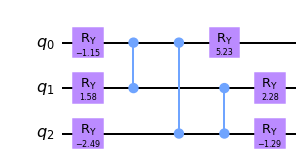

In [21]:
theta_0 = np.random.uniform(-2 * np.pi, 2 * np.pi, size=6)

ansatz = build_ansatz(theta_0)

ansatz.draw(output='mpl')

In [160]:
backend = Aer.get_backend('statevector_simulator')

In [189]:
A = 0.55 * (I ^ I ^ I) \
    + 0.225 * (I ^ Z ^ I) \
        + 0.225 * (I ^ I ^ Z)

B = (H ^ H ^ H).to_pauli_op()

[[ 0.35355339+0.j  0.35355339+0.j  0.35355339+0.j  0.35355339+0.j
   0.35355339+0.j  0.35355339+0.j  0.35355339+0.j  0.35355339+0.j]
 [ 0.35355339+0.j -0.35355339+0.j  0.35355339+0.j -0.35355339+0.j
   0.35355339+0.j -0.35355339+0.j  0.35355339+0.j -0.35355339+0.j]
 [ 0.35355339+0.j  0.35355339+0.j -0.35355339+0.j -0.35355339+0.j
   0.35355339+0.j  0.35355339+0.j -0.35355339+0.j -0.35355339+0.j]
 [ 0.35355339+0.j -0.35355339+0.j -0.35355339+0.j  0.35355339+0.j
   0.35355339+0.j -0.35355339+0.j -0.35355339+0.j  0.35355339+0.j]
 [ 0.35355339+0.j  0.35355339+0.j  0.35355339+0.j  0.35355339+0.j
  -0.35355339+0.j -0.35355339+0.j -0.35355339+0.j -0.35355339+0.j]
 [ 0.35355339+0.j -0.35355339+0.j  0.35355339+0.j -0.35355339+0.j
  -0.35355339+0.j  0.35355339+0.j -0.35355339+0.j  0.35355339+0.j]
 [ 0.35355339+0.j  0.35355339+0.j -0.35355339+0.j -0.35355339+0.j
  -0.35355339+0.j -0.35355339+0.j  0.35355339+0.j  0.35355339+0.j]
 [ 0.35355339+0.j -0.35355339+0.j -0.35355339+0.j  0.35355339+0.j
  -

In [190]:
A

PauliSumOp(SparsePauliOp(['III', 'IZI', 'IIZ'],
              coeffs=[0.55 +0.j, 0.225+0.j, 0.225+0.j]), coeff=1.0)

In [191]:
B

SummedOp([PauliOp(Pauli('XXX'), coeff=0.3535533905932737), PauliOp(Pauli('XXZ'), coeff=0.3535533905932737), PauliOp(Pauli('XZX'), coeff=0.3535533905932737), PauliOp(Pauli('XZZ'), coeff=0.3535533905932737), PauliOp(Pauli('ZXX'), coeff=0.3535533905932737), PauliOp(Pauli('ZXZ'), coeff=0.3535533905932737), PauliOp(Pauli('ZZX'), coeff=0.3535533905932737), PauliOp(Pauli('ZZZ'), coeff=0.3535533905932737)], coeff=1.0, abelian=False)

In [192]:
A_squared = (~A) @ A

In [230]:
print(~A)

0.55 * III
+ 0.225 * IZI
+ 0.225 * IIZ


In [194]:
zero_proj = 0.5 * (I + Z)
zero_proj_3 = zero_proj ^ zero_proj ^ zero_proj

In [195]:
print(zero_proj_3.to_matrix())

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]]


In [196]:
A_b_proj = (~A) @ (~B) @ zero_proj_3 @ B @ A

In [197]:
print(A_b_proj)

ComposedOp([
  0.55 * III
  + 0.225 * IZI
  + 0.225 * IIZ,
  SummedOp([
    0.3535533905932737 * XXX,
    0.3535533905932737 * XXZ,
    0.3535533905932737 * XZX,
    0.3535533905932737 * XZZ,
    0.3535533905932737 * ZXX,
    0.3535533905932737 * ZXZ,
    0.3535533905932737 * ZZX,
    0.3535533905932737 * ZZZ
  ]),
  0.125 * III
  + 0.125 * IIZ
  + 0.125 * IZI
  + 0.125 * IZZ
  + 0.125 * ZII
  + 0.125 * ZIZ
  + 0.125 * ZZI
  + 0.125 * ZZZ,
  SummedOp([
    0.3535533905932737 * XXX,
    0.3535533905932737 * XXZ,
    0.3535533905932737 * XZX,
    0.3535533905932737 * XZZ,
    0.3535533905932737 * ZXX,
    0.3535533905932737 * ZXZ,
    0.3535533905932737 * ZZX,
    0.3535533905932737 * ZZZ
  ]),
  0.55 * III
  + 0.225 * IZI
  + 0.225 * IIZ
])


In [16]:
ansatz = TwoLocal(3, 'ry', 'cz', 'full', reps=1, insert_barriers=True)
# fig = ansatz.decompose().draw(output='mpl')
# fig.savefig('ansatz.png', bbox_inches='tight')
print(ansatz.assign_parameters(theta_0).decompose().qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q[3];
ry(-0.627577910588899) q[0];
ry(0.608833308240603) q[1];
ry(-0.434913409877861) q[2];
barrier q[0],q[1],q[2];
cz q[0],q[1];
cz q[0],q[2];
cz q[1],q[2];
barrier q[0],q[1],q[2];
ry(3.39208404016469) q[0];
ry(-2.97268895158477) q[1];
ry(-5.01574960076825) q[2];



In [14]:
theta_0 = np.random.uniform(-2 * np.pi, 2 * np.pi, size=ansatz.num_parameters)
# print(theta_0)
# psi = CircuitStateFn(ansatz.assign_parameters(theta_0))
# print(psi)

In [79]:
ev1 = StateFn(A_squared).adjoint().eval(psi)
ev2 = StateFn(A_b_proj).adjoint().eval(psi)
print(ev1.real)
print(ev2.real)
# expectation = AerPauliExpectation().convert(measurable)
# sampler = CircuitSampler(backend).convert(expectation)  
# print('Snapshot:', sampler.eval().real) 

0.37311992427648655
0.15629807532942014


In [251]:
def cost(params):
    """
    Returns the global un-normalized cost function for VQLS:
    C_G = <\psi| (~A (1-|b><b|) A) |\psi>
    """
    psi = CircuitStateFn(ansatz.assign_parameters(params))
    
    ev1 = StateFn(A_squared).adjoint().eval(psi)
    ev2 = StateFn(A_b_proj).adjoint().eval(psi)

    return ev1.real - ev2.real

In [252]:
out = minimize(cost, x0=theta_0, method="COBYLA", options={'maxiter':500})
print(out)

     fun: 1.702769435174556e-08
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 268
  status: 1
 success: True
       x: array([-2.69235195, -3.43220098, -3.14092646, -0.81663543,  6.16219595,
       -1.57221482])


In [253]:
theta_opt = out.x
zero_state = Statevector.from_label('000')
psi_opt = zero_state.evolve(ansatz.assign_parameters(theta_opt))
psi_opt_vector = psi_opt.data
print(psi_opt_vector)

[-0.06822417+0.j -0.12409873+0.j -0.12385793+0.j -0.68192812+0.j
 -0.06813169+0.j -0.12387863+0.j -0.12395813+0.j -0.68134041+0.j]


In [254]:
A.to_matrix()
# B.to_matrix()

array([[1.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.55+0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.55+0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.1 +0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 1.  +0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.55+0.j,
        0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.55+0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.1 +0.j]])

In [255]:
np.linalg.norm((A.to_matrix().real @ psi_opt_vector.real) - (1/np.sqrt(8) * np.ones(8)))

1.1928170965030842

In [256]:
zero_state = Statevector.from_label('000')
b_ket = B.to_matrix() @ zero_state.data
print(b_ket)
print(1/np.sqrt(8) * np.ones(8))

[0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j
 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j]
[0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
 0.35355339 0.35355339]


In [260]:
x_true = np.linalg.solve(A.to_matrix(), (1/np.sqrt(8) * np.ones(8)))
print(x_true)
print(np.linalg.norm(x_true))

[0.35355339+0.j 0.64282435+0.j 0.64282435+0.j 3.53553391+0.j
 0.35355339+0.j 0.64282435+0.j 0.64282435+0.j 3.53553391+0.j]
5.186799838241634


In [258]:
x_true[0] / psi_opt_vector[0]

(-5.1822310952685875-0j)

In [259]:
5.1822 * psi_opt_vector

array([-0.35355127+0.j, -0.64310442+0.j, -0.64185657+0.j, -3.53388792+0.j,
       -0.35307203+0.j, -0.64196385+0.j, -0.6423758 +0.j, -3.53084229+0.j])